Create a model for the mutual impedance matrix of an array of parallel dipole antenna elements. Choose from the following options for the model:

 Commercial software package: If you have access to software like HFSS, EMPIRE, studentversion of FEKO, NEC, or any other similar package, use the commercial package to find the mutual impedance matrix and open circuit loaded embedded element patterns for the dipole array.

Using HFSS I created a 2 element ULA array with half wave dipoles. I created the element and used the array tool simulating it at 1 GHz. Below is the Z-matrix which should be the mutual coupling matrix.

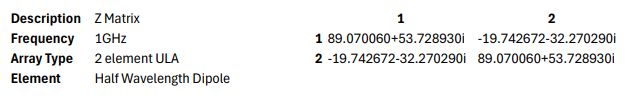

In [29]:
from IPython.display import Image
from IPython.core.display import HTML 

# show work done by hand
display(Image("HW13-ZParameters.png", width=500, height=500))

Problem 4.8

Write a script to find the directivity of a 4 element ULA of isotropic radiators using the overlap integral. Plot the broadside directivity as a function of element spacing over the range $0 \leq d \leq 3\lambda$. 

Overlay the directivity obtained with the conjugate field match solution.

C:\Users\small\AppData\Local\Temp\ipykernel_31740\3490174606.py:76: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  B[m, n] = Ep[m] * Ep[n].conj()  # Compute signal response equation 4.66


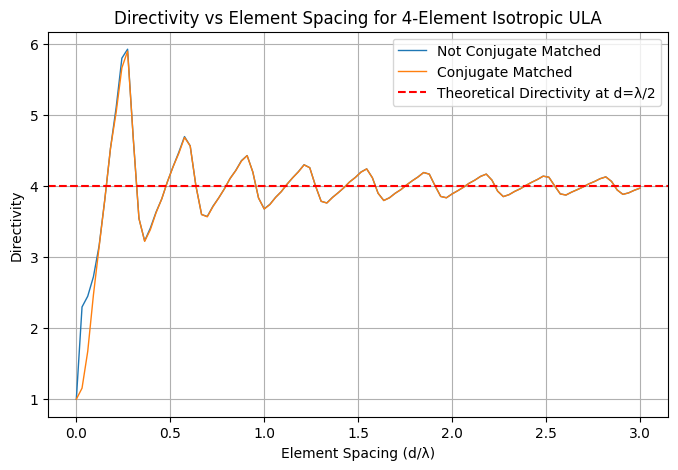

In [30]:
#FOLLOWING THE STEPS OUTLINE IN SECTION 4.14.1 APPLYING THE LOSSLESS RESONANT MINIMUM SCATTERING APPROXIMATION
#EACH ELEMENT IS A HALF-WAVE DIPOLE

########### IMPORTS #############
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as spi



########################################### VARIABLES ############################################
# Define antenna parameters
f = 1e9                 # Frequency in Hz
c = 3e8                 # Speed of light in m/s
lam = c / f             # Wavelength in m
k = 2 * np.pi / lam     # Wave number
eta = 377               # Intrinsic impedance of free space
Prad = 1                # Radiated power
r = 1                   # Observation distance
l = lam / 2             # Half-wave dipole length
Im = 1                  # Mutual impedance
theta = np.pi/2          # broadside
#theta = 0               # endfire

# Define element spacing range
num_points = 100
d_values = np.linspace(0, 3*lam, num_points)  # Range of element spacings

# Number of elements in the array
N = 4

# empty array of directivity values
directivity_values = []
directivity_values_cm = []




################################################## MAIN ##########################################################
for d in d_values:
    ## Define the receiver positions ##
    rx = np.array([n * d for n in range(N)])    # Positions of elements

    ## compute Ep ##
    E0 = np.sqrt(2*eta*Prad/(4*np.pi*r**2))
    E_el = E0 * np.exp(1j*k*r)  # E-field of an isotropic radiator
    Ep = np.zeros((N, 1), dtype=complex)                        # Initialize electric field
    # Ep loop for broadside
    for n in range(N):
        Ep[n] = E_el*np.exp(1j*k*d*np.cos(theta)*rx[n])         # Compute phase shifted electric field vector
    #print("Ep \n", Ep)                                         # debug e-field

    ## compute the overlap matrix ##
    A = np.zeros((N, N))                # initialize the overlap matrix
    for m in range(N):
        for n in range(N):
            r_mn = rx[m] - rx[n]        # distance between elements
            A[m, n] = np.sinc(k*r_mn)   # assign the value of the integral to the overlap matrix
    #print("Overlap Matrix \n", A)      # debug overlap matrix           
    
    ## compute mutual impedance matrix ##
    # scalar = 2/np.abs(Im)**2    # Equation 4.108
    # Za = scalar * A             # mutual impedance matrix
    #print("Mutual Impedance Matrix \n", Za) # debug mutual impedance matrix
    
    ## Compute weights ##
    A_inv = np.linalg.pinv(A)                   # invert overlap
    w = np.dot(A_inv, Ep)                       # Compute weights equation 4.86
    #print("weights \n", w)                     # debug weights
    w_cm = Ep                                   # Conjugate matched weights

    ## compute signal response ##
    B = np.zeros((N, N), dtype=complex)     # Initialize signal response
    for m in range(N):
        for n in range(N):
            B[m, n] = Ep[m] * Ep[n].conj()  # Compute signal response equation 4.66
    B = B / (2 * eta)                       # Normalize signal response
    #print("B \n", B)                        # debug signal response
    
    ## Compute Directivity using equation 4.63 ##
    w_herm = w.conj().T                         # Compute hermitian of weights
    #print("hermitian of weights \n", w_herm)   # debug hermitian of weights
    scalar = 4 * np.pi * (r**2) / Prad           # Compute directivity scalar
    wB = np.dot(w_herm, B)
    numerator = np.dot(wB, w)
    wA = np.dot(w_herm, A)
    denominator = np.dot(wA, w)
    D = scalar * numerator / denominator        # Compute directivity equation 4.63
    # D = D / (4*np.pi*r**2)                      # Normalize directivity
    #print("Directivity \n", D)                 # debug directivity

    ## Compute Conjugate Matched Directivity ##
    w_herm = w_cm.conj().T
    #print("hermitian of weights \n", w_herm)
    wB = np.dot(w_herm, B)
    numerator = np.dot(wB, w_cm)
    wA = np.dot(w_herm, A)
    denominator = np.dot(wA, w_cm)
    D_cm = scalar * numerator / denominator         # Compute directivity equation 4.63
    # D_cm = D_cm / (4*np.pi*r**2)                    # Normalize directivity
    #print("Directivity \n", D_cm)                  # debug directivity

    # append zeros
    directivity_values.append(D[0,0])
    directivity_values_cm.append(D_cm[0,0])

# equation 4.90 used as a target directivity
Del = 1              # directivity of a half-wave dipole
d_theoretical = N * Del # theoretical directivity of the array


####################################################### PLOTS ###########################################################
plt.figure(figsize=(8, 5))
plt.plot(d_values / lam, directivity_values, label="Not Conjugate Matched", linewidth=1)
plt.plot(d_values / lam, directivity_values_cm, label="Conjugate Matched", linewidth=1)
plt.axhline(y=d_theoretical, color='r', linestyle='--', label="Theoretical Directivity at d=λ/2")  # Reference line
plt.xlabel("Element Spacing (d/λ)")
plt.ylabel("Directivity")
plt.title("Directivity vs Element Spacing for 4-Element Isotropic ULA")
plt.grid(True)
plt.legend()
plt.show() 

C:\Users\small\AppData\Local\Temp\ipykernel_31740\3346869575.py:48: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  B[m, n] = Ep[m] * Ep[n].conj()  # Compute signal response equation 4.66


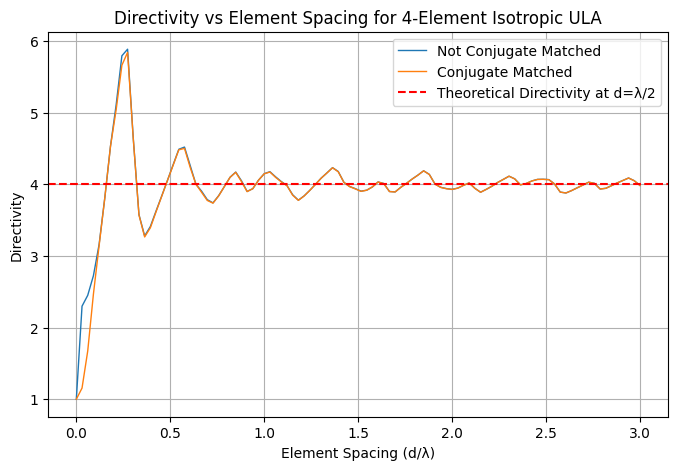

In [31]:
# set to endfire
theta = 0

# empty array of directivity values
directivity_values = []
directivity_values_cm = []




################################################## MAIN ##########################################################
for d in d_values:
    ## Define the receiver positions ##
    rx = np.array([n * d for n in range(N)])    # Positions of elements

    ## compute Ep ##
    E0 = np.sqrt(2*eta*Prad/(4*np.pi*r**2))
    E_el = E0 * np.exp(1j*k*r)  # E-field of an isotropic radiator
    Ep = np.zeros((N, 1), dtype=complex)                        # Initialize electric field
    # Ep loop for broadside
    for n in range(N):
        Ep[n] = E_el*np.exp(1j*k*d*np.cos(theta)*rx[n])         # Compute phase shifted electric field vector
    #print("Ep \n", Ep)                                         # debug e-field

    ## compute the overlap matrix ##
    A = np.zeros((N, N))                # initialize the overlap matrix
    for m in range(N):
        for n in range(N):
            r_mn = rx[m] - rx[n]        # distance between elements
            A[m, n] = np.sinc(k*r_mn)   # assign the value of the integral to the overlap matrix
    #print("Overlap Matrix \n", A)      # debug overlap matrix           
    
    ## compute mutual impedance matrix ##
    # scalar = 2/np.abs(Im)**2    # Equation 4.108
    # Za = scalar * A             # mutual impedance matrix
    #print("Mutual Impedance Matrix \n", Za) # debug mutual impedance matrix
    
    ## Compute weights ##
    A_inv = np.linalg.pinv(A)                   # invert overlap
    w = np.dot(A_inv, Ep)                       # Compute weights equation 4.86
    #print("weights \n", w)                     # debug weights
    w_cm = Ep                                   # Conjugate matched weights

    ## compute signal response ##
    B = np.zeros((N, N), dtype=complex)     # Initialize signal response
    for m in range(N):
        for n in range(N):
            B[m, n] = Ep[m] * Ep[n].conj()  # Compute signal response equation 4.66
    B = B / (2 * eta)                       # Normalize signal response
    #print("B \n", B)                        # debug signal response
    
    ## Compute Directivity using equation 4.63 ##
    w_herm = w.conj().T                         # Compute hermitian of weights
    #print("hermitian of weights \n", w_herm)   # debug hermitian of weights
    scalar = 4 * np.pi * (r**2) / Prad           # Compute directivity scalar
    wB = np.dot(w_herm, B)
    numerator = np.dot(wB, w)
    wA = np.dot(w_herm, A)
    denominator = np.dot(wA, w)
    D = scalar * numerator / denominator        # Compute directivity equation 4.63
    # D = D / (4*np.pi*r**2)                      # Normalize directivity
    #print("Directivity \n", D)                 # debug directivity

    ## Compute Conjugate Matched Directivity ##
    w_herm = w_cm.conj().T
    #print("hermitian of weights \n", w_herm)
    wB = np.dot(w_herm, B)
    numerator = np.dot(wB, w_cm)
    wA = np.dot(w_herm, A)
    denominator = np.dot(wA, w_cm)
    D_cm = scalar * numerator / denominator         # Compute directivity equation 4.63
    # D_cm = D_cm / (4*np.pi*r**2)                    # Normalize directivity
    #print("Directivity \n", D_cm)                  # debug directivity

    # append zeros
    directivity_values.append(D[0,0])
    directivity_values_cm.append(D_cm[0,0])

# equation 4.90 used as a target directivity
Del = 1              # directivity of a half-wave dipole
d_theoretical = N * Del # theoretical directivity of the array


####################################################### PLOTS ###########################################################
plt.figure(figsize=(8, 5))
plt.plot(d_values / lam, directivity_values, label="Not Conjugate Matched", linewidth=1)
plt.plot(d_values / lam, directivity_values_cm, label="Conjugate Matched", linewidth=1)
plt.axhline(y=d_theoretical, color='r', linestyle='--', label="Theoretical Directivity at d=λ/2")  # Reference line
plt.xlabel("Element Spacing (d/λ)")
plt.ylabel("Directivity")
plt.title("Directivity vs Element Spacing for 4-Element Isotropic ULA")
plt.grid(True)
plt.legend()
plt.show() 

4.9 Repeat problem 4.8 using the LRMSA method for half wave dipoles.

C:\Users\small\AppData\Local\Temp\ipykernel_31740\3805653761.py:63: ComplexWarning: Casting complex values to real discards the imaginary part
  A[i, j] = I                                           # assign the value of the integral to the overlap matrix


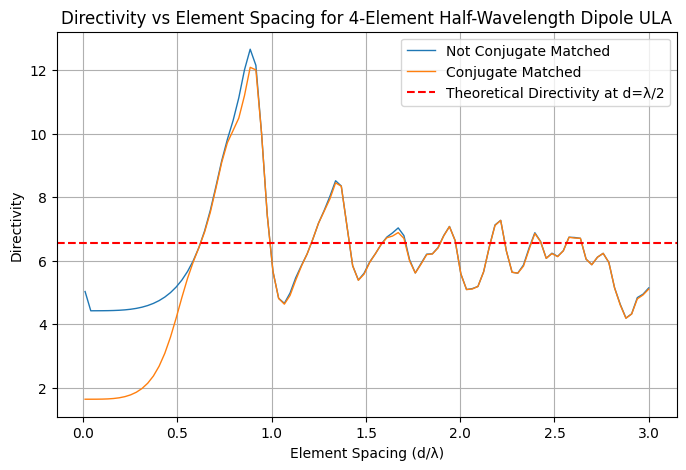

In [32]:
########################################### VARIABLES ############################################
# Define antenna parameters
f = 300e6                 # Frequency in Hz
c = 3e8                 # Speed of light in m/s
lam = c / f             # Wavelength in m
k = 2 * np.pi / lam     # Wave number
eta = 377               # Intrinsic impedance of free space
Pel = 1                 # Radiated power
r = 1                   # Observation distance
l = lam / 2             # Half-wave dipole length
Im = 1                  # Mutual impedance
theta = np.pi/2        # broadside or endfire
phi = np.pi/2           # parallel to the array axis

# Define element spacing range
num_points = 100
d_values = np.linspace(0.01*lam, 3*lam, num_points)  # Range of element spacings
#d_values = np.array([lam/2])
# Number of elements in the array
N = 4

# empty array of directivity values
directivity_values = []
directivity_values_cm = []

################################################## MAIN ##########################################################
for d in d_values:
    ## Define the receiver positions ##
    rx = np.array([n * d for n in range(N)])    # Positions of elements
    #print("rx \n", rx)                          # debug receiver positions

    ## compute the vector of phase shifted electric fields ##
    E0 = 1j * Im * eta / (2 * np.pi * r)                                          # Amplitude of the E-Field of a dipole on page 84
    E_el = E0 * (np.cos(k*l*np.cos(theta)/2)-np.cos(k*l/2)) / np.sin(theta) # E-field of a dipole
    Ep = np.zeros(N, dtype=complex)                                    # Initialize electric field
    # Ep loop for broadside
    for n in range(N):
        Ep[n] = E_el*np.exp(1j*k*d*np.sin(phi)*np.cos(theta)*(rx[n]-rx[0]))         # Compute electric field
    #print("Ep \n", Ep)                                                     # debug e-field

    ## compute the overlap matrix ##
    A = np.zeros((N, N))                                          # initialize the overlap matrix
    points = 50
    for i in range(N):
        for j in range(N):
            # numerical implementation of the quadrature rule according to equations 4.69 and 4.70
            I = 0                                                 # initialize the integral
            del_phi = 2*np.pi/points                                   # integration weights
            del_theta = del_phi                                   # integration weights
            for m in range(points):
                phi_m = (m - 1/2) * del_phi                       # midpoint for each integration step
                for n in range(int(points/2)):
                    theta_n = (n - 1/2) * del_theta               # midpoint for each integration step

                    # integrand
                    Em = E0 * (np.cos(k*l*np.cos(theta_n)/2)-np.cos(k*l/2)) / np.sin(theta_n) * np.exp(1j*k*d*np.sin(theta_n)*np.cos(phi_m)*rx[i])
                    En = E0 * (np.cos(k*l*np.cos(theta_n)/2)-np.cos(k*l/2)) / np.sin(theta_n) * np.exp(1j*k*d*np.sin(theta_n)*np.cos(phi_m)*rx[j])

                    I += Em * np.conj(En) * np.sin(theta_n) * del_phi * del_theta   # integral approximation
                    #print("I\n", I)                               # debug integral                     
            #print("I \n", I)                                      # debug integral                                 

            A[i, j] = I                                           # assign the value of the integral to the overlap matrix
    
    ## compute the mutual impedance matrix ##
    A = A / (2*eta)
    scalar = 2/np.abs(Im)**2    # Equation 4.108
    Za = scalar * A             # mutual impedance matrix
    #print(Za)                   # debug mutual impedance matrix
          
    ## Compute weights ##
    A_inv = np.linalg.inv(A)                  # invert overlap       
    w = np.dot(A_inv, Ep)                       # Compute weights equation 4.86
    #print("weights \n", w)                     # debug weights
    w_cm = Ep                                   # Conjugate matched weights
    #print("weights_cm \n", w_cm)                # debug conjugate matched weights

    ## compute signal response ##
    B = np.zeros((N, N), dtype=complex)     # Initialize signal response
    for m in range(N):
        for n in range(N):
            B[m, n] = Ep[m] * Ep[n].conj()  # Compute signal response equation 4.66
    B = B / (2 * eta)                       # Normalize signal response
    #print("B \n", B)                        # debug signal response

    ## Compute Directivity using equation 4.63 ##
    w_herm = w.conj().T                         # Compute hermitian of weights
    #print("hermitian of weights \n", w_herm)   # debug hermitian of weights
    scalar = 4 * np.pi * (r**2)                 # Compute directivity scalar
    wB = w_herm @ B
    numerator = wB @ w  
    wA = w_herm @ A
    denominator = wA @ w
    D = scalar * numerator / denominator        # Compute directivity equation 4.63
    #print("Directivity \n", D)                 # debug directivity

    ## Compute Conjugate Matched Directivity ##
    w_herm = w_cm.conj().T
    #print("hermitian of weights \n", w_herm)   # debug hermitian of weights
    wB =  w_herm @ B
    wA =  w_herm @ A
    numerator = wB @ w_cm
    denominator = wA @ w_cm
    D_cm = scalar * numerator / denominator         # Compute directivity equation 4.63
    #print("Directivity \n", D_cm)                  # debug directivity

    # append zeros
    directivity_values.append(D)
    directivity_values_cm.append(D_cm)
    #print(k*d)

# equation 4.90 used as a target directivity
Del = 1.64              # directivity of a half-wave dipole
d_theoretical = N * Del # theoretical directivity of the array


####################################################### PLOTS ###########################################################
plt.figure(figsize=(8, 5))
plt.plot(d_values / lam, directivity_values, label="Not Conjugate Matched", linewidth=1)
plt.plot(d_values / lam, directivity_values_cm, label="Conjugate Matched", linewidth=1)
plt.axhline(y=d_theoretical, color='r', linestyle='--', label="Theoretical Directivity at d=λ/2")  # Reference line
plt.xlabel("Element Spacing (d/λ)")
plt.ylabel("Directivity")
plt.title("Directivity vs Element Spacing for 4-Element Half-Wavelength Dipole ULA")
plt.grid(True)
plt.legend()
plt.show() 

C:\Users\small\AppData\Local\Temp\ipykernel_31740\4272025615.py:63: ComplexWarning: Casting complex values to real discards the imaginary part
  A[i, j] = I                                           # assign the value of the integral to the overlap matrix


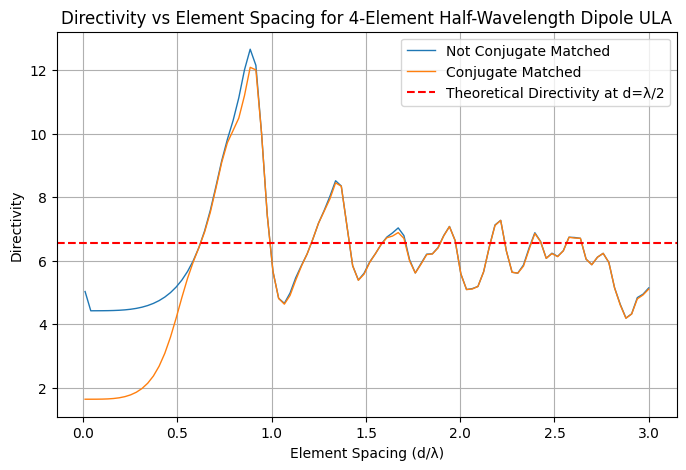

In [33]:
########################################### VARIABLES ############################################
# Define antenna parameters
f = 300e6                 # Frequency in Hz
c = 3e8                 # Speed of light in m/s
lam = c / f             # Wavelength in m
k = 2 * np.pi / lam     # Wave number
eta = 377               # Intrinsic impedance of free space
Pel = 1                 # Radiated power
r = 1                   # Observation distance
l = lam / 2             # Half-wave dipole length
Im = 1                  # Mutual impedance
theta = np.pi/2        # broadside or endfire
phi = 0           # parallel to the array axis

# Define element spacing range
num_points = 100
d_values = np.linspace(0.01*lam, 3*lam, num_points)  # Range of element spacings
#d_values = np.array([lam/2])
# Number of elements in the array
N = 4

# empty array of directivity values
directivity_values = []
directivity_values_cm = []

################################################## MAIN ##########################################################
for d in d_values:
    ## Define the receiver positions ##
    rx = np.array([n * d for n in range(N)])    # Positions of elements
    #print("rx \n", rx)                          # debug receiver positions

    ## compute the vector of phase shifted electric fields ##
    E0 = 1j * Im * eta / (2 * np.pi * r)                                          # Amplitude of the E-Field of a dipole on page 84
    E_el = E0 * (np.cos(k*l*np.cos(theta)/2)-np.cos(k*l/2)) / np.sin(theta) # E-field of a dipole
    Ep = np.zeros(N, dtype=complex)                                    # Initialize electric field
    # Ep loop for broadside
    for n in range(N):
        Ep[n] = E_el*np.exp(1j*k*d*np.sin(phi)*np.cos(theta)*(rx[n]-rx[0]))         # Compute electric field
    #print("Ep \n", Ep)                                                     # debug e-field

    ## compute the overlap matrix ##
    A = np.zeros((N, N))                                          # initialize the overlap matrix
    points = 50
    for i in range(N):
        for j in range(N):
            # numerical implementation of the quadrature rule according to equations 4.69 and 4.70
            I = 0                                                 # initialize the integral
            del_phi = 2*np.pi/points                                   # integration weights
            del_theta = del_phi                                   # integration weights
            for m in range(points):
                phi_m = (m - 1/2) * del_phi                       # midpoint for each integration step
                for n in range(int(points/2)):
                    theta_n = (n - 1/2) * del_theta               # midpoint for each integration step

                    # integrand
                    Em = E0 * (np.cos(k*l*np.cos(theta_n)/2)-np.cos(k*l/2)) / np.sin(theta_n) * np.exp(1j*k*d*np.sin(theta_n)*np.cos(phi_m)*rx[i])
                    En = E0 * (np.cos(k*l*np.cos(theta_n)/2)-np.cos(k*l/2)) / np.sin(theta_n) * np.exp(1j*k*d*np.sin(theta_n)*np.cos(phi_m)*rx[j])

                    I += Em * np.conj(En) * np.sin(theta_n) * del_phi * del_theta   # integral approximation
                    #print("I\n", I)                               # debug integral                     
            #print("I \n", I)                                      # debug integral                                 

            A[i, j] = I                                           # assign the value of the integral to the overlap matrix
    
    ## compute the mutual impedance matrix ##
    A = A / (2*eta)
    scalar = 2/np.abs(Im)**2    # Equation 4.108
    Za = scalar * A             # mutual impedance matrix
    #print(Za)                   # debug mutual impedance matrix
          
    ## Compute weights ##
    A_inv = np.linalg.inv(A)                  # invert overlap       
    w = np.dot(A_inv, Ep)                       # Compute weights equation 4.86
    #print("weights \n", w)                     # debug weights
    w_cm = Ep                                   # Conjugate matched weights
    #print("weights_cm \n", w_cm)                # debug conjugate matched weights

    ## compute signal response ##
    B = np.zeros((N, N), dtype=complex)     # Initialize signal response
    for m in range(N):
        for n in range(N):
            B[m, n] = Ep[m] * Ep[n].conj()  # Compute signal response equation 4.66
    B = B / (2 * eta)                       # Normalize signal response
    #print("B \n", B)                        # debug signal response

    ## Compute Directivity using equation 4.63 ##
    w_herm = w.conj().T                         # Compute hermitian of weights
    #print("hermitian of weights \n", w_herm)   # debug hermitian of weights
    scalar = 4 * np.pi * (r**2)                 # Compute directivity scalar
    wB = w_herm @ B
    numerator = wB @ w  
    wA = w_herm @ A
    denominator = wA @ w
    D = scalar * numerator / denominator        # Compute directivity equation 4.63
    #print("Directivity \n", D)                 # debug directivity

    ## Compute Conjugate Matched Directivity ##
    w_herm = w_cm.conj().T
    #print("hermitian of weights \n", w_herm)   # debug hermitian of weights
    wB =  w_herm @ B
    wA =  w_herm @ A
    numerator = wB @ w_cm
    denominator = wA @ w_cm
    D_cm = scalar * numerator / denominator         # Compute directivity equation 4.63
    #print("Directivity \n", D_cm)                  # debug directivity

    # append zeros
    directivity_values.append(D)
    directivity_values_cm.append(D_cm)
    #print(k*d)

# equation 4.90 used as a target directivity
Del = 1.64              # directivity of a half-wave dipole
d_theoretical = N * Del # theoretical directivity of the array


####################################################### PLOTS ###########################################################
plt.figure(figsize=(8, 5))
plt.plot(d_values / lam, directivity_values, label="Not Conjugate Matched", linewidth=1)
plt.plot(d_values / lam, directivity_values_cm, label="Conjugate Matched", linewidth=1)
plt.axhline(y=d_theoretical, color='r', linestyle='--', label="Theoretical Directivity at d=λ/2")  # Reference line
plt.xlabel("Element Spacing (d/λ)")
plt.ylabel("Directivity")
plt.title("Directivity vs Element Spacing for 4-Element Half-Wavelength Dipole ULA")
plt.grid(True)
plt.legend()
plt.show() 